# Notebook #5: Serie temporal: parámetros p=3, d=0, q=4

In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_temporales as st
from src import soporte_sarima as ss
from src import soporte_funciones_BBDD as sfbd
from src import soporte_variables_defunciones as svd

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Calcular métricas
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

# Query para traer datos agrupados

In [2]:
df_defunciones = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svd.query_EDA_1)

In [3]:
df_defunciones.head()

,fecha,casos_defunciones
0,2007-01-01,146
1,2007-02-01,136
2,2007-03-01,156
3,2007-04-01,147
4,2007-05-01,117


# Defunciones

In [4]:
df_copia = df_defunciones.copy()
df_copia['fecha'] = pd.to_datetime(df_copia['fecha'])
df_copia["Month"] = df_copia["fecha"].dt.month_name()
df_copia["Year"] = df_copia["fecha"].dt.year
df_copia.head()

,fecha,casos_defunciones,Month,Year
0,2007-01-01,146,January,2007
1,2007-02-01,136,February,2007
2,2007-03-01,156,March,2007
3,2007-04-01,147,April,2007
4,2007-05-01,117,May,2007


In [5]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_copia, temporal_column="fecha", value_column="casos_defunciones")

analisis_st.exploracion_datos()

El número de filas es 204 y el número de columnas es 3

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
casos_defunciones,204,154,25,77,137,153,169,208
Year,204,2015,5,2007,2011,2015,2019,2023


In [ ]:
analisis_st.comprobar_serie_continua() #comprobamos si la serie es continua en meses

La serie temporal es continua para la frecuencia 'M', no faltan periodos.


In [7]:
analisis_st.graficar_serie()

### Análisis de la Serie Temporal de Accidentes

La gráfica ilustra una **serie temporal de defunciones** con valores que oscilan entre 80 y 200, mostrando comportamientos interesantes que merecen ser destacados.

#### Observaciones clave:

1. **Patrones cíclicos y estacionalidad**:
   - Se aprecian **picos regulares** en ciertos meses, lo que sugiere una **estacionalidad** marcada. Esto podría estar vinculado a eventos como:
     - Festividades o vacaciones, donde la movilización aumenta.
     - Cambios estacionales que pueden influir en las condiciones de tránsito.

2. **Ausencia de tendencia de largo plazo**:
   - La serie temporal no muestra un patrón de crecimiento o disminución sostenida a lo largo de los años.
   - Sin embargo, la **oscilación alrededor de una media aparente** indica que las defunciones fluctúan de forma consistente en un rango determinado.

3. **Período 2016-2020**:
   - Este período destaca por una **caída pronunciada** en las defunciones, seguida de un aumento acelerado.
   - En **2020**, se observa una caída significativa en las cifras, que puede estar asociada a:
     - **Restricciones de movilidad** impuestas durante la pandemia de COVID-19.
     - Una menor actividad social y económica durante este tiempo.

4. **Restablecimiento posterior a 2020**:
   - A partir de finales de **2020** y durante **2021-2022**, las cifras comienzan a estabilizarse, recuperándose hacia los valores históricos.
   - Esto sugiere una **vuelta a la normalidad** en términos de movilidad y comportamiento social.

5. **Variabilidad mensual significativa**:
   - Las fluctuaciones de un mes a otro son notables, lo que indica que no solo hay estacionalidad, sino que también pueden influir eventos específicos o variaciones puntuales en la movilidad.


In [ ]:
analisis_st.graficar_media_movil(window=12) #comprobamos el comportamiento en 12 meses

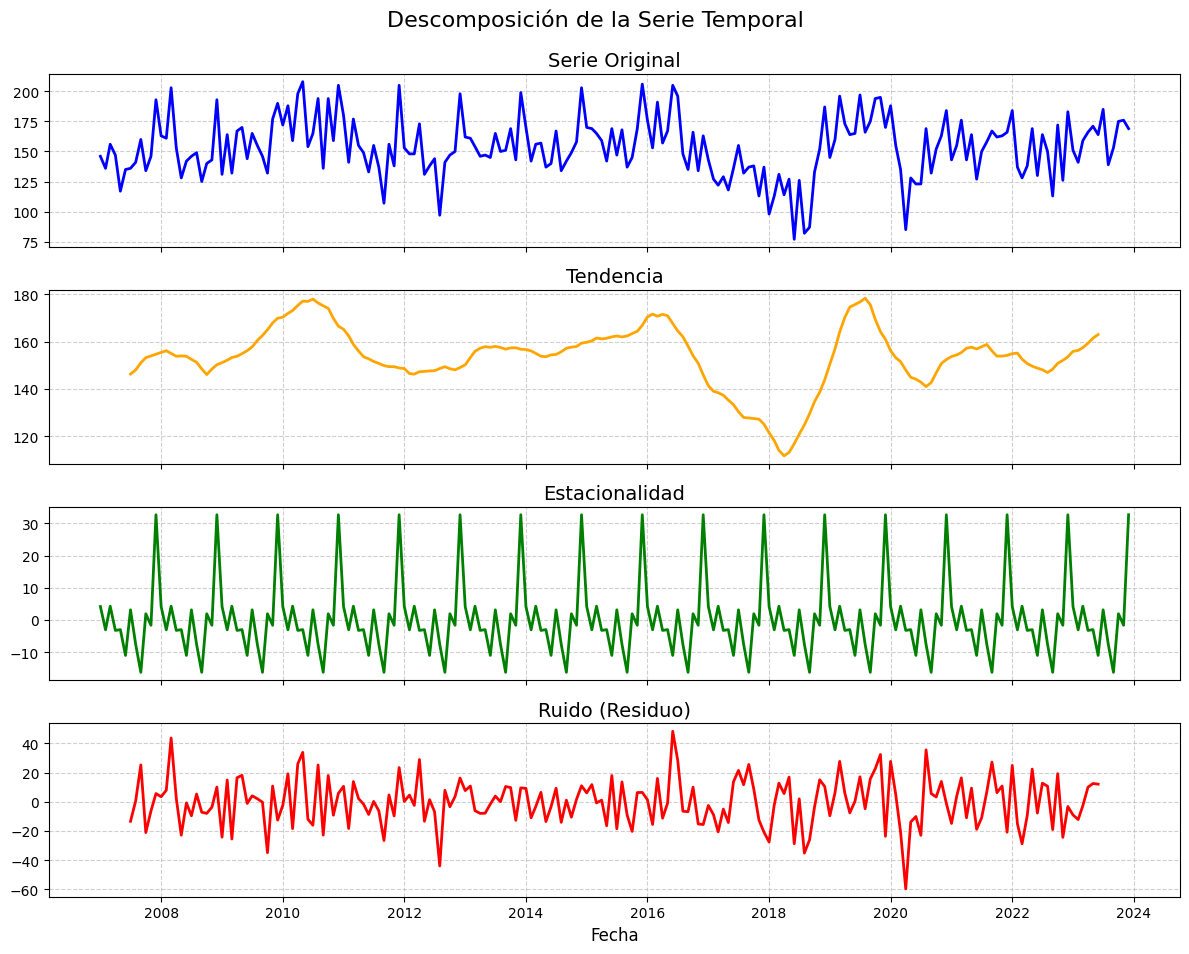

In [9]:
analisis_st.detectar_estacionalidad()

# Análisis de autocorrelación

<Figure size 1200x1000 with 0 Axes>

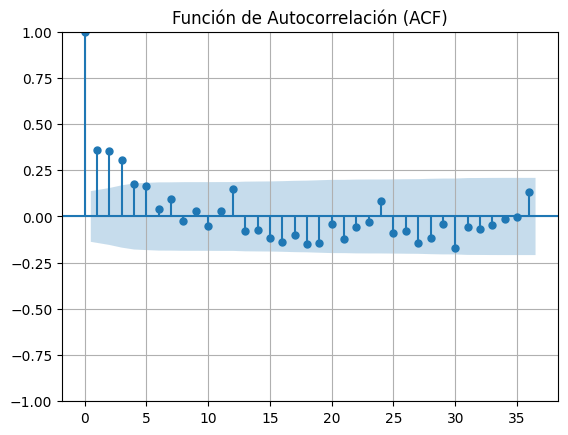

<Figure size 1200x1000 with 0 Axes>

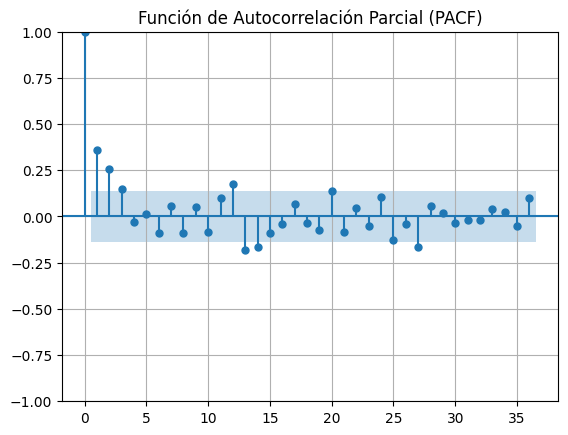

In [10]:
analisis_st.graficar_acf_pacf(lags=36)

## Interpretación de los lags

## Análisis de las Gráficas ACF y PACF

### **Gráfica ACF (Función de Autocorrelación)**
1. **Lag 1**:
   - La correlación en el primer lag es muy alta (cercana a 0.75), lo que indica que la variable tiene una fuerte relación con su valor del periodo inmediatamente anterior.
   
2. **Lags significativos**:
   - Los lags 2 y 3 tienen correlaciones significativas que sobresalen del intervalo de confianza, lo que sugiere que también tienen impacto en la serie.
   - Después del tercer lag, las correlaciones disminuyen gradualmente y se acercan al intervalo de confianza.

3. **Tendencia a cero**:
   - La autocorrelación disminuye de manera lenta y persistente, lo que podría ser indicativo de no estacionaridad o una estructura autorregresiva en la serie.

4. **Estacionalidad**:
   - Se presenta un pico cada 12 lags, lo que sugiere un patrón anual. Este rebote es lo que demuestra la estacionalidad de la serie   
---

### **Gráfica PACF (Función de Autocorrelación Parcial)**
1. **Lag 1**:
   - El primer lag muestra una correlación significativa (cercana a 0.75), indicando que el valor actual está altamente influenciado por el valor del periodo inmediatamente anterior.

2. **Lags significativos**:
   - Los lags 2 y 3 también son significativos, aunque con menor intensidad, lo que indica que las correlaciones directas entre estos lags y el valor actual son importantes.

3. **Lags posteriores**:
   - A partir del lag 4, las barras caen dentro del intervalo de confianza, lo que implica que los lags más lejanos no tienen una influencia directa significativa.

---

In [11]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -3.6734269015355294
p-value: 0.004502839670564938
Valores Críticos:
1%: -3.4652439354133255
5%: -2.8768752281673717
10%: -2.574944653739612
Rechazamos la hipótesis nula. La serie es estacionaria.


    - La serie es estacionaria de acuerdo al ADF Test.

In [12]:
df_defunciones.set_index('fecha', inplace=True)

### Cálculo del baseline

In [ ]:
df_defunciones['prev'] = df_defunciones['casos_defunciones'].shift(1) #toma como valor el valor anterior
df_defunciones['ape'] = (df_defunciones['prev'] - df_defunciones['casos_defunciones']).abs() / df_defunciones['casos_defunciones'].astype(float)

df_defunciones.head()

,casos_defunciones,prev,ape
fecha,,,
2007-01-01,146,NaN,NaN
2007-02-01,136,146,0
2007-03-01,156,136,0
2007-04-01,147,156,0
2007-05-01,117,147,0


Para el baseline, tomamos como referencia el mes anterior. De manera que tomamos como base que las predicciones del próximo mes serán iguales a las del mes actual.

## Dividimos la serie en train-test

In [14]:
train_size = int(0.7 * len(df_defunciones))
y_train, y_test = df_defunciones[:train_size], df_defunciones[train_size:]

### Resultado del baseline del modelo

In [15]:
y_test['ape'].mean()

0.15147392089250838

    - Como baseline, tenemos un MAPE de 15.14%. 

In [16]:
df_defunciones.drop(columns=['prev', 'ape'], inplace=True)
y_train.drop(columns=['prev', 'ape'], inplace=True)
y_test.drop(columns=['prev', 'ape'], inplace=True)

In [17]:
sarima = ss.SARIMAModel()

# Definir los rangos para los parámetros
p_range = range(4)
q_range = range(5)
seasonal_order_ranges = (
    range(2),  # P
    range(2),  # D
    range(2),  # Q
    [12]       # S
)

# Generar parámetros
parametros = sarima.generar_parametros(p_range, q_range, seasonal_order_ranges)
parametros[:5] # Ver algunas combinaciones

[(0, 0, (0, 0, 0, 12)),
 (0, 0, (0, 0, 1, 12)),
 (0, 0, (0, 1, 0, 12)),
 (0, 0, (0, 1, 1, 12)),
 (0, 0, (1, 0, 0, 12))]

## Probar el modelo para el y_test

100%|██████████| 160/160 [00:46<00:00,  3.47it/s]


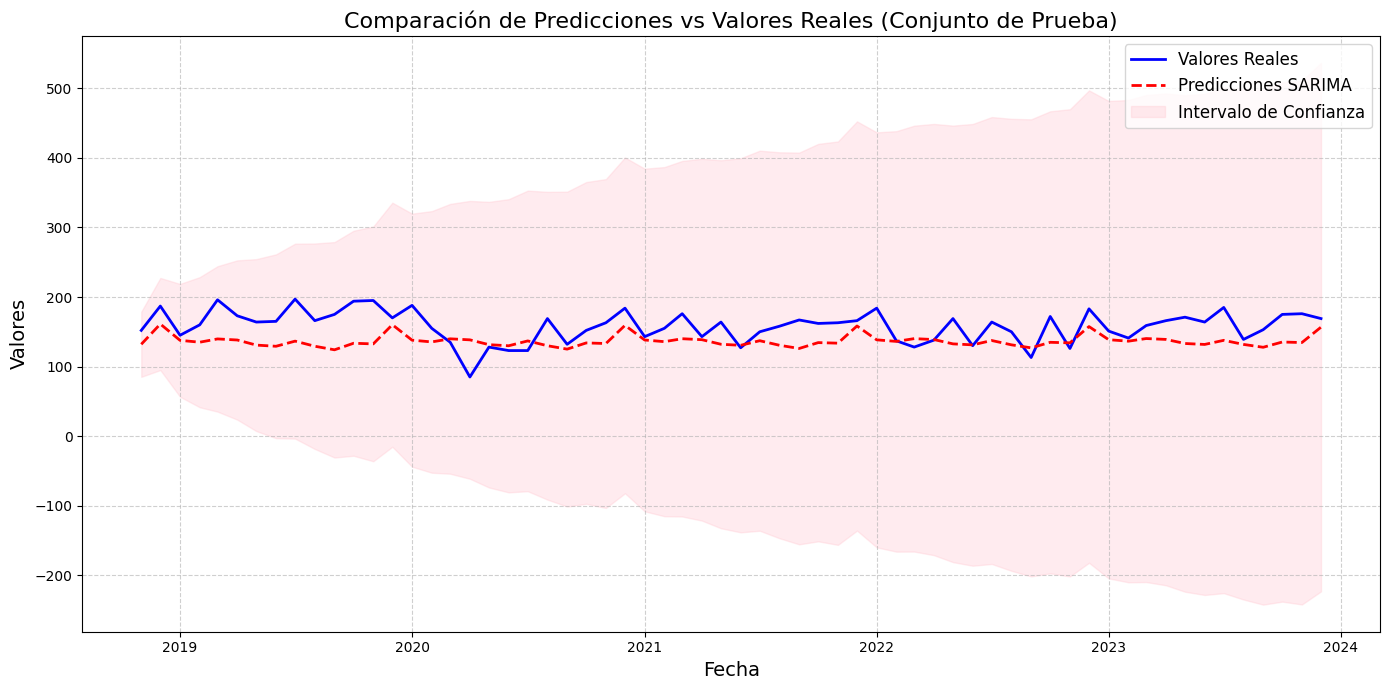

In [18]:
results_df = sarima.evaluar_modelos(y_train, y_test, parametros, diferenciacion=1, df_length=len(df_defunciones), variable="casos_defunciones")

In [19]:
results_df.sort_values(by='RMSE', ascending=True).head()

,p,q,seasonal_order,RMSE
5,0,0,"(1, 0, 1, 12)",30
0,0,0,"(0, 0, 0, 12)",33
7,0,0,"(1, 1, 1, 12)",34
3,0,0,"(0, 1, 1, 12)",34
1,0,0,"(0, 0, 1, 12)",34


    - Hemos recibido que las mejores métricas para **seasonal_order** son (1,0,1,12). Las vamos a utilizar para entrenar nuestro modelo. Esto con los valores que recibimos de ACF y PACF.

## Modelo

In [20]:
modelo_sarima= SARIMAX(df_defunciones, 
                    order= (3,0,4),                    # al ser mi serie estacionaria probamos con d=0
                    seasonal_order= (1,0,1,12)).fit()   #Se pone la p, la d y la q con 1 porque se añade S que es el componente estacional en este caso 12 
                                            
pred_y= modelo_sarima.predict(start= len(df_defunciones), end=len(df_defunciones)+23)   #pongo el más 24 porque son los que quiero predecir

pred_y= pred_y.astype(int) # predicciones a futuro, próximos 24 meses
datos_predichos=pd.DataFrame(pred_y)

In [21]:
y_test.index = pd.to_datetime(y_test.index)
datos_predichos.index = pd.to_datetime(datos_predichos.index)

In [39]:
datos_predichos['anio'] = datos_predichos.index.year
datos_predichos.tail()

,predicted_mean,anio
2025-08-01,144,2025
2025-09-01,139,2025
2025-10-01,153,2025
2025-11-01,151,2025
2025-12-01,175,2025


In [23]:
datos_predichos.groupby('anio')['predicted_mean'].sum()

anio
2024    1875
2025    1816
Name: predicted_mean, dtype: int32

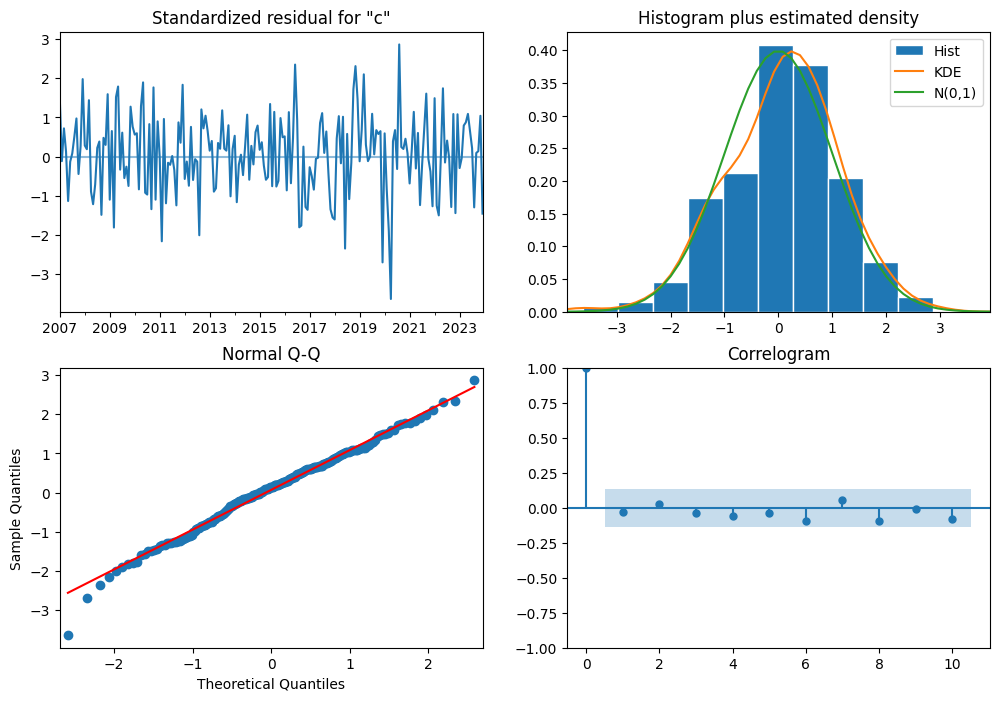

In [24]:
modelo_sarima.plot_diagnostics(figsize=(12, 8))
plt.show()

### Métricas para el y_test

In [25]:
# Predicción para el rango de y_test
pred_y_test = modelo_sarima.predict(start=y_test.index.min(), end=y_test.index.max())

# Crear DataFrame alineado
datos_predichos_y_test = pd.DataFrame(pred_y_test, columns=['predicted_mean'])
datos_predichos_y_test.index = y_test.index

mae = mean_absolute_error(y_test['casos_defunciones'], datos_predichos_y_test['predicted_mean'])
mape = mean_absolute_percentage_error(y_test['casos_defunciones'], datos_predichos_y_test['predicted_mean'])
rmse = np.sqrt(mean_squared_error(y_test['casos_defunciones'], datos_predichos_y_test['predicted_mean']))
print(f"MAE: {mae}, MAPE: {mape * 100:.2f}% , RMSE: {rmse}")

MAE: 16.501059558266476, MAPE: 11.06% , RMSE: 22.167746562001817


    - En general, los valores de mis métricas son bastante buenos. Sin embargo, tomaré en cuenta con mayor validez su peso al utilizar todos los datos.

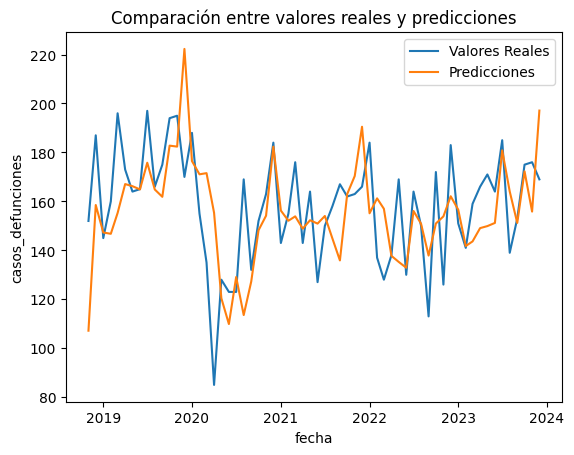

In [26]:
sns.lineplot(x=y_test.index, y=y_test['casos_defunciones'], label="Valores Reales") # valores de mi y_test
sns.lineplot(x=y_test.index, y=datos_predichos_y_test['predicted_mean'], label="Predicciones") # valores predichos para el conjunto y_test
plt.title("Comparación entre valores reales y predicciones")
plt.show()

## Métricas para el modelo completo

### Resultados del Modelo

#### MAE: 16.00
Este resultado indica que el modelo, en promedio, comete un error absoluto de **16 casos de defunciones al mes**. Para evaluar si este es un buen resultado, debemos compararlo con la magnitud promedio de los datos. Si la serie tiene valores cercanos a este rango (por ejemplo, entre 100 y 200), este **MAE es aceptable**.

#### MAPE: 10.84%
Un **MAPE del 10.84%** significa que el error porcentual promedio es de aproximadamente el **11%** en relación con los valores reales. En general, un **MAPE por debajo del 10%-15%** se considera aceptable. Esto indica que el modelo tiene un desempeño razonable, aunque todavía existe margen de mejora.

#### RMSE: 20.22
El **RMSE de 20.22** penaliza más los errores grandes debido a su cálculo basado en la raíz cuadrada del error cuadrático promedio. Al comparar este valor con el MAE (16.49), la diferencia no es significativa, lo que sugiere que no hay errores extremadamente grandes en las predicciones realizadas por el modelo.

---

### Conclusión
Estas métricas reflejan que el modelo **captura bien el comportamiento general de la serie**, mostrando un desempeño sólido en la predicción de casos de defunciones mensuales.


In [27]:
# Predicción en toda la serie histórica
pred_toda_serie = modelo_sarima.predict(start=df_defunciones.index.min(), end=df_defunciones.index.max())

# Crear DataFrame para las predicciones
datos_predichos_toda_serie = pd.DataFrame(pred_toda_serie, columns=['predicted_mean'])
datos_predichos_toda_serie.index = df_defunciones.index

# Calcular métricas de error en toda la serie
mae_toda_serie = mean_absolute_error(df_defunciones['casos_defunciones'], datos_predichos_toda_serie['predicted_mean'])
mape_toda_serie = mean_absolute_percentage_error(df_defunciones['casos_defunciones'], datos_predichos_toda_serie['predicted_mean'])
rmse = np.sqrt(mean_squared_error(df_defunciones['casos_defunciones'], datos_predichos_toda_serie['predicted_mean']))

print(f"MAE para toda la serie: {mae_toda_serie}")
print(f"MAPE para toda la serie: {mape_toda_serie * 100:.2f}%")
print(f'RMSE para toda la serie: {rmse}')

MAE para toda la serie: 16.64075273195455
MAPE para toda la serie: 11.28%
RMSE para toda la serie: 22.616493873773315


## Métricas excluyendo el primer elemento, cálculo más preciso de métricas

In [28]:
# Predicción en toda la serie histórica
pred_toda_serie = modelo_sarima.predict(start=df_defunciones.index.min(), end=df_defunciones.index.max())

# Crear DataFrame para las predicciones
datos_predichos_toda_serie = pd.DataFrame(pred_toda_serie, columns=['predicted_mean'])
datos_predichos_toda_serie.index = df_defunciones.index

# Calcular métricas de error en toda la serie
mae_toda_serie = mean_absolute_error(df_defunciones['casos_defunciones'][1:], datos_predichos_toda_serie['predicted_mean'][1:])
mape_toda_serie = mean_absolute_percentage_error(df_defunciones['casos_defunciones'][1:], datos_predichos_toda_serie['predicted_mean'][1:])
rmse = np.sqrt(mean_squared_error(df_defunciones['casos_defunciones'][1:], datos_predichos_toda_serie['predicted_mean'][1:]))

print(f"MAE para toda la serie: {mae_toda_serie}")
print(f"MAPE para toda la serie: {mape_toda_serie * 100:.2f}%")
print(f'RMSE para toda la serie: {rmse}')

MAE para toda la serie: 16.003515060683387
MAPE para toda la serie: 10.84%
RMSE para toda la serie: 20.224257761783214


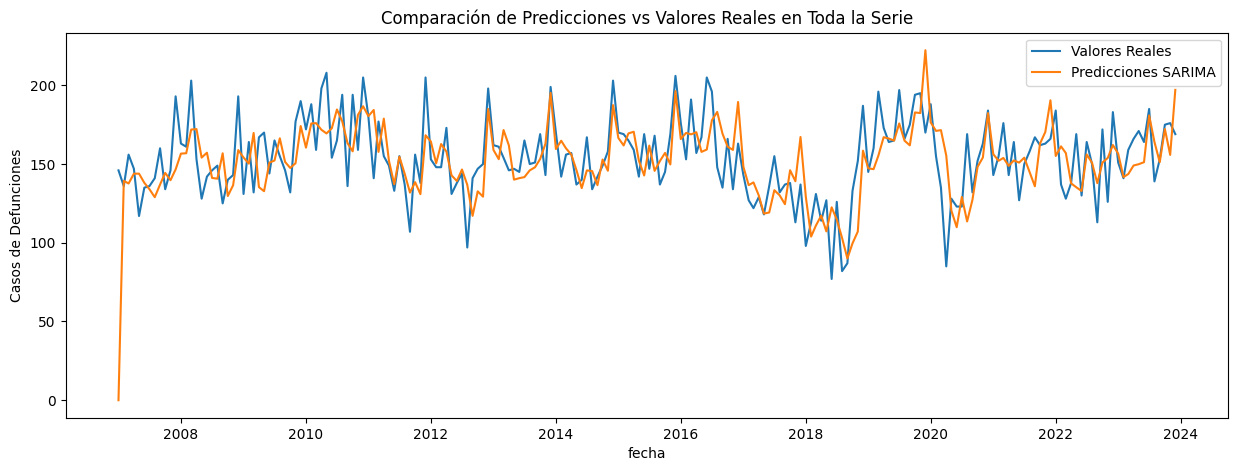

In [29]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=df_defunciones.index, y=df_defunciones['casos_defunciones'], label='Valores Reales')
sns.lineplot(x=datos_predichos_toda_serie.index, y=datos_predichos_toda_serie['predicted_mean'], label='Predicciones SARIMA')
plt.title("Comparación de Predicciones vs Valores Reales en Toda la Serie")
plt.ylabel("Casos de Defunciones")
plt.legend()
plt.show()

### Predicción a futuro (2 años)

## Análisis de las Predicciones a Futuro

### 1. **Tendencia General**
- El modelo proyecta un comportamiento que se alinea con la tendencia histórica de los datos. Los valores predichos oscilan entre **143 y 180 defunciones al mes**, lo que coincide con el rango observado en los datos históricos.
- Este rango sugiere que no se esperan cambios drásticos en la cantidad de defunciones mensuales en los próximos dos años, manteniendo la estabilidad observada en el pasado reciente.

### 2. **Patrón Estacional**
- Las predicciones confirman la **estacionalidad** de los datos, con un incremento constante en las defunciones en los últimos meses del año, especialmente en **diciembre**.
- Este comportamiento refuerza la hipótesis de que factores estacionales, como las festividades, el aumento de la movilidad y posiblemente el consumo de alcohol, influyen significativamente en la cantidad de accidentes viales.

### 3. **Rango de Valores Predichos**
- Aunque los valores están dentro del rango esperado, el modelo refleja ligeras fluctuaciones mes a mes, lo cual es normal en un fenómeno tan dinámico como los accidentes viales.
- Los valores más bajos (por ejemplo, **141 en septiembre de 2024**) podrían estar relacionados con meses históricamente más tranquilos en términos de accidentes.

### 4. **Consistencia con la Serie Histórica**
- La consistencia entre las predicciones y los datos históricos es un indicador de que el modelo está ajustado correctamente y es capaz de capturar tanto la tendencia como la estacionalidad de la serie.
- La proyección no muestra signos de cambios inesperados, lo que sugiere que las condiciones que afectan la cantidad de accidentes viales se mantendrán similares en el futuro cercano.

---


Text(0.5, 1.0, 'Predicción a futuro de defunciones producto de accidentes viales en República Dominicana')

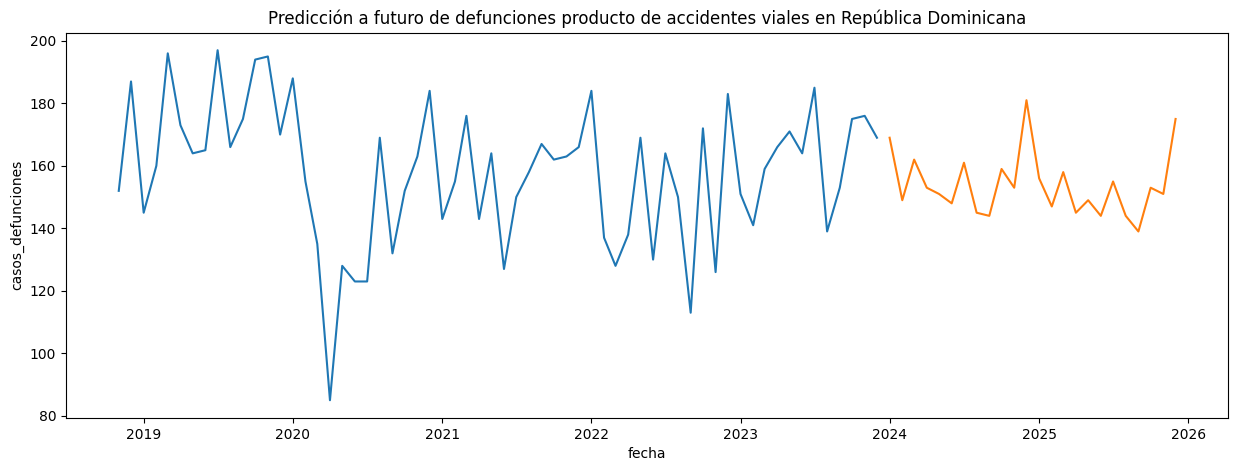

In [30]:
plt.figure(figsize=(15,5))

sns.lineplot(x=y_test.index, y='casos_defunciones', data=y_test)
sns.lineplot(x=datos_predichos.index, y='predicted_mean', data=datos_predichos)
plt.title('Predicción a futuro de defunciones producto de accidentes viales en República Dominicana')

Text(0.5, 1.0, 'Predicción a futuro de defunciones producto de accidentes viales en República Dominicana')

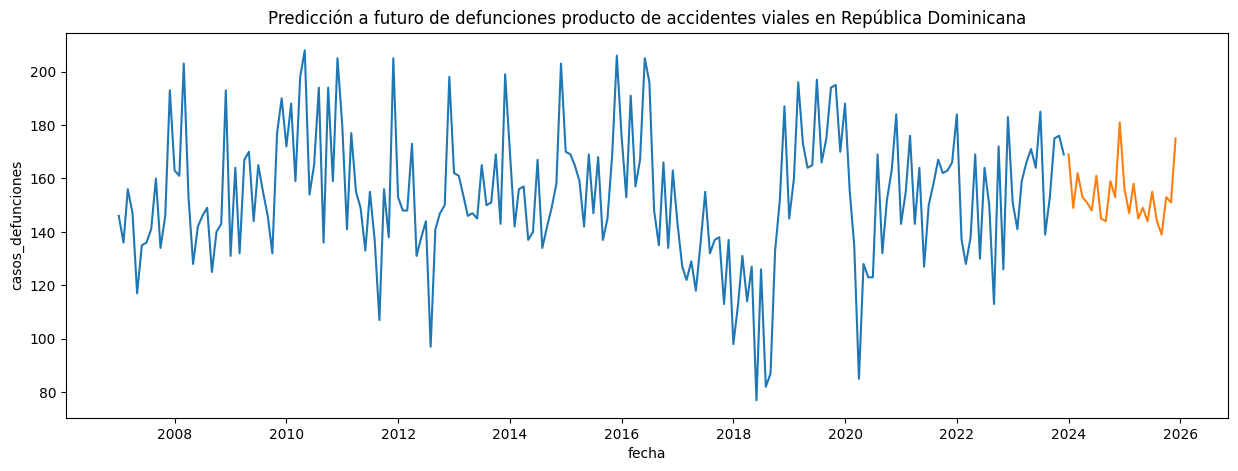

In [31]:
plt.figure(figsize=(15,5))
sns.lineplot(x=df_defunciones.index, y=df_defunciones['casos_defunciones'], data=df_defunciones)
sns.lineplot(x=datos_predichos.index, y='predicted_mean', data=datos_predichos)
plt.title('Predicción a futuro de defunciones producto de accidentes viales en República Dominicana')

In [32]:
datos_predichos_toda_serie_copia = datos_predichos_toda_serie.copy()
datos_predichos_copia = datos_predichos.copy()

In [33]:
datos_predichos_toda_serie_copia.reset_index(inplace=True)
datos_predichos_copia.reset_index(inplace=True)
datos_predichos_copia.drop(columns='anio', inplace=True)

In [34]:
datos_predichos_toda_serie_copia = datos_predichos_toda_serie_copia[1:]

In [35]:
datos_predichos_copia.columns = ['fecha', 'predicted_mean']

In [36]:
df_combined = pd.concat([datos_predichos_toda_serie_copia, datos_predichos_copia], axis=0)

In [37]:
df_combined['fecha'] = pd.to_datetime(df_combined['fecha'])

In [38]:
df_combined.to_csv('../../Datos/datos_predichos/df_defunciones_predichas.csv')

In [43]:
datos_predichos.groupby('anio')['predicted_mean'].sum()

anio
2024    1875
2025    1816
Name: predicted_mean, dtype: int32